### Load everything

In [136]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report

In [137]:
# Read the data files
train_data = pd.read_csv("data/train.csv", index_col=0)
test_data = pd.read_csv("data/test.csv", index_col=0)

In [138]:
# Select the features
feature_cols = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

In [139]:
# Slice the data and create X, y and test_data
X = train_data.loc[:, feature_cols]
y = train_data["Survived"]
test_data = test_data.loc[:, feature_cols]
test_data_passenger_ids = test_data.index # We will need this later to save as csv

print(X.head())
print(test_data.head())

             Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                      
1                 3    male  22.0      1      0   7.2500        S
2                 1  female  38.0      1      0  71.2833        C
3                 3  female  26.0      0      0   7.9250        S
4                 1  female  35.0      1      0  53.1000        S
5                 3    male  35.0      0      0   8.0500        S
             Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                      
892               3    male  34.5      0      0   7.8292        Q
893               3  female  47.0      1      0   7.0000        S
894               2    male  62.0      0      0   9.6875        Q
895               3    male  27.0      0      0   8.6625        S
896               3  female  22.0      1      1  12.2875        S


### Preprocessing

In [140]:
# Fill the missing data with the mean of corresponding series
age_imputer = Imputer()
fare_imputer = Imputer()

X["Age"] = age_imputer.fit_transform(X["Age"].values.reshape((len(X), 1)))
test_data["Age"] = age_imputer.transform(test_data["Age"].values.reshape((len(test_data), 1)))

fare_imputer.fit(X["Fare"].values.reshape((len(X), 1)))
test_data["Fare"] = fare_imputer.transform(test_data["Fare"].values.reshape((len(test_data), 1)))

In [141]:
# Encode the labels to numeric values
le_sex = LabelEncoder()
le_embarked = LabelEncoder()

X["Sex"] = le_sex.fit_transform(X["Sex"])
X["Embarked"] = le_embarked.fit_transform(X["Embarked"].apply(str))

test_data["Sex"] = le_sex.transform(test_data["Sex"])
test_data["Embarked"] = le_embarked.transform(test_data["Embarked"].apply(str))

## Feature Selection

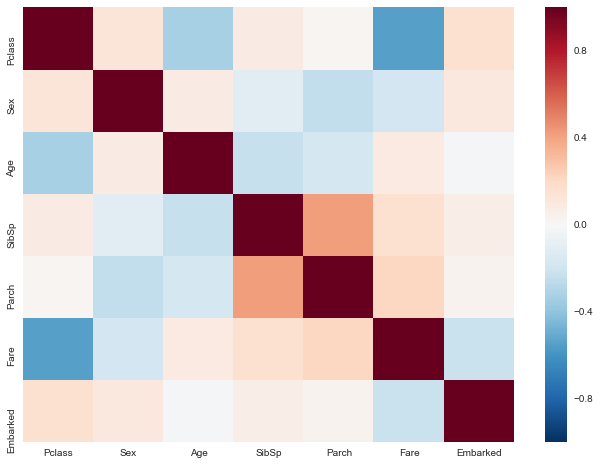

In [142]:
# Correlation and heatmap
%matplotlib inline

corr = X.corr()
fig = plt.figure(figsize=(11, 8))
sns.heatmap(corr, figure=fig)
plt.show()

In [143]:
# Create dummy variables and remove the optional one
embarked_ohe = OneHotEncoder(categorical_features=[-1])

X = embarked_ohe.fit_transform(X).toarray()[:, 1:]
test_data = embarked_ohe.transform(test_data).toarray()[:, 1:]

In [144]:
# Scale the data
X_scale = StandardScaler()

X = X_scale.fit_transform(X)
test_data = X_scale.transform(test_data)

In [145]:
# Feature selection
clf = RandomForestClassifier(random_state=3)
clf.fit(X, y)
print(clf.feature_importances_)

new_feature_cols = [3, 4, 5, 6, 7, 8] # Pclass, Sex, Age, SibSp, Parch, Fare

X = X[:, new_feature_cols]
test_data = test_data[:, new_feature_cols]

[ 0.00623972  0.01902158  0.          0.08406742  0.29092393  0.25536967
  0.04515501  0.02662838  0.27259427]


## Hyperparameter Optimization

In [146]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [147]:
# Select model/classifier
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "GBC"
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=3),
    SVC(gamma=2, C=1, random_state=3),
    GaussianProcessClassifier(warm_start=True, random_state=3),
    DecisionTreeClassifier(max_depth=5, random_state=3),
    RandomForestClassifier(max_depth=5, n_estimators=100, random_state=3),
    MLPClassifier(alpha=1, random_state=3),
    AdaBoostClassifier(random_state=3),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier(random_state=3)
]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = recall_score(y_pred, y_test)
    print(name, accuracy)


Logistic Regression 0.68
Nearest Neighbors 0.722222222222
Linear SVM 0.716216216216
RBF SVM 0.674698795181
Gaussian Process 0.746478873239
Decision Tree 0.786885245902
Random Forest 0.704225352113
Neural Net 0.72602739726
AdaBoost 0.670886075949
Naive Bayes 0.657534246575
QDA 0.722222222222
GBC 0.761904761905


In [184]:
# Optimize hyperparameter
clf = GradientBoostingClassifier()

param_grid = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [0.05, 0.1],
    "n_estimators": np.arange(100, 1001, 50),
    "max_depth": np.arange(1, 6, 1),
    "random_state": [3]
}

grid = GridSearchCV(clf, param_grid, "precision", cv=3, n_jobs=-1) # Change the value of n_jobs to 1 if your computer is old
grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.05, 0.1], 'n_estimators': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]), 'loss': ['deviance', 'exponential'], 'max_depth': array([1, 2, 3, 4, 5]), 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [186]:
# Print results

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.810640971931
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=3,
              subsample=1.0, verbose=0, warm_start=False)
{'learning_rate': 0.05, 'random_state': 3, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 150}


## Final Model

In [188]:
# Create the final model/classifier for test
clf = GradientBoostingClassifier(**grid.best_params_)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=3,
              subsample=1.0, verbose=0, warm_start=False)

In [189]:
# Compute accuracy and create confusion matrix
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Accuracy: {}%".format(round(accuracy*100), 1))
print("Confusion Matrix: ")
print(cm)
print("Classification Report: ")
print(cr)

Accuracy: 78.0%
Confusion Matrix: 
[[85 24]
 [16 54]]
Classification Report: 
             precision    recall  f1-score   support

          0       0.84      0.78      0.81       109
          1       0.69      0.77      0.73        70

avg / total       0.78      0.78      0.78       179



In [182]:
# Create the final model/classifier for submission
clf = GradientBoostingClassifier(**grid.best_params_)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=3,
              subsample=1.0, verbose=0, warm_start=False)

In [183]:
# Save the predicted data as csv
prediction = clf.predict(test_data)
prediction = pd.DataFrame({"PassengerId": test_data_passenger_ids, "Survived": prediction})
prediction.to_csv("data/prediction.csv", index=None)

### Kaggle Accuracy Result: 77.0% (0.77033)